In [1]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import folium # map rendering library

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

pd.options.mode.chained_assignment = None

# A Simple Hotel Recommendation Based on Attractions Distances and Hotel Rating

# 1 Introduction

For those who like to travel with more freedom, it is sometimes hard and time-consuming to choose which hotel to stay based on a number of tourist attractions planning to go in a way that would shorten the time between the hotel and attractions. It would be nice to be able to choose a hotel based on the distance to tourist attractions and hotels’ rating as a simple recommendation. The further potential application might be a smart trip planning application if local transportation information is easily available.

# 2 Data

1. We want the user to input the city, the number of tourist attractions planning and the minimum rating. 
2. We also want the user to specify hotels' minimum rating so hotels of poor rating will not be recommended.

In [2]:
city = 'Toronto'
num_attr_to_go = 4
min_attr_rating = 7
min_hotel_rating = 8

3. Then, tourist attractions and nearby hotels' geographical locations will be queried using the Foursquare API to calculate the distance from the hotel to attractions. For data of hotels and attractions without a rating, geographical information or category, it will be filtered.

In [3]:
# Geographical location of Toronto
tt_latitude = 43.653963
tt_longitude = -79.387207
print('The geograpical coordinate of Toronto are {}, {}.'.format(tt_latitude, tt_longitude))

The geograpical coordinate of Toronto are 43.653963, -79.387207.


In [4]:
# Search for attractions using foursquare api
url_attr = ('https://api.foursquare.com/v2/'
    'search/recommendations?locale=en&explicit-lang=false&'
    'v=20190702&'
    'm=foursquare&'
    'query=Attraction&'
    'll=43.653963,-79.387207&'
    'limit=100&'
    'radius=20000&'
    'wsid=3ON5SYSE1F5HB2HFVRUEWYYIAIM4HK&'
    'oauth_token=Z2ZGPZBA1A5LSTJDHCQZ2GY43HNKTNL1UVTHQ5KR3E1G1XGN')

print(url_attr)
results_attr = requests.get(url_attr).json()


https://api.foursquare.com/v2/search/recommendations?locale=en&explicit-lang=false&v=20190702&m=foursquare&query=Attraction&ll=43.653963,-79.387207&limit=100&radius=20000&wsid=3ON5SYSE1F5HB2HFVRUEWYYIAIM4HK&oauth_token=Z2ZGPZBA1A5LSTJDHCQZ2GY43HNKTNL1UVTHQ5KR3E1G1XGN


In [5]:
# Json to dataframe
attr = results_attr['response']['group']['results']
df_attr = json_normalize(attr) # flatten JSON

# Filter columns
filtered_columns = ['venue.name', 'venue.rating', 'venue.location.city','venue.location.lat', 'venue.location.lng','venue.categories']
df_attr = df_attr.loc[:, filtered_columns]

In [6]:
# Function that extracts the category of the venue
def get_category_type(row):
    categories_list = 0
    try:
        categories_list = row['venue.categories']
        return categories_list[0]['name']
    except:
        return None

In [7]:
# Filter the category for each row
df_attr['venue.categories'] = df_attr.apply(get_category_type, axis=1)

In [8]:
interested_category = ['History Museum',
                       'Theme Park',
                       'Castle','Park',
                       'Museum',
                       'Monument and Landmark',
                       'Historic Site',
                       'Trail',
                       'Scenic Lookout']
print("Interested category:")
print(interested_category)

Interested category:
['History Museum', 'Theme Park', 'Castle', 'Park', 'Museum', 'Monument and Landmark', 'Historic Site', 'Trail', 'Scenic Lookout']


In [9]:
def isWanted(row):
    return row['venue.categories'] in interested_category and \
            row['venue.rating'] >= min_attr_rating and \
            row['venue.location.city'] == city

df_attr = df_attr[df_attr.apply(isWanted,axis=1)]
df_attr.reset_index(drop=True,inplace=True)

In [10]:
# Clean columns
df_attr.columns = [col.split(".")[-1] for col in df_attr.columns]
df_attr.head()

,name,rating,city,lat,lng,categories
0,Centreville Amusement Park,8.1,Toronto,43.620370,-79.373792,Theme Park
1,Casa Loma,8.8,Toronto,43.677934,-79.409521,Castle
2,The Distillery Historic District,9.3,Toronto,43.650244,-79.359323,Historic Site
3,Royal Ontario Museum,9.1,Toronto,43.668367,-79.394813,Museum
4,Spadina Museum: Historic House & Gardens,7.4,Toronto,43.678883,-79.408858,History Museum


In [11]:
print('{} tourist attractions were returned by Foursquare API.'.format(df_attr.shape[0]))

5 tourist attractions were returned by Foursquare API.


In [12]:
# Search for hotels using foursquare api
url_hotel = ('https://api.foursquare.com/v2/'
    'search/recommendations?locale=en&explicit-lang=false&'
    'v=20190702&'
    'm=foursquare&'
    'query=Hotel&'
    'll=43.653963,-79.387207&'
    'limit=100&'
    'radius=20000&'
    'wsid=3ON5SYSE1F5HB2HFVRUEWYYIAIM4HK&'
    'oauth_token=Z2ZGPZBA1A5LSTJDHCQZ2GY43HNKTNL1UVTHQ5KR3E1G1XGN')
print(url_hotel)

results_hotel = requests.get(url_hotel).json()

https://api.foursquare.com/v2/search/recommendations?locale=en&explicit-lang=false&v=20190702&m=foursquare&query=Hotel&ll=43.653963,-79.387207&limit=100&radius=20000&wsid=3ON5SYSE1F5HB2HFVRUEWYYIAIM4HK&oauth_token=Z2ZGPZBA1A5LSTJDHCQZ2GY43HNKTNL1UVTHQ5KR3E1G1XGN


In [13]:
df_hotels = results_hotel['response']['group']['results']
df_hotels = json_normalize(df_hotels) # flatten JSON

# filter columns
df_hotels = df_hotels.loc[:, filtered_columns]

df_hotels.dropna(subset=["venue.categories","venue.rating"], axis=0, inplace=True)
df_hotels.reset_index(drop=True, inplace=True)

# filter the category for each row
df_hotels['venue.categories'] = df_hotels.apply(get_category_type, axis=1)

In [14]:
interested_category_hotel = 'Hotel'

def is_at_Toronto(row):
    return  row['venue.categories'] in interested_category_hotel and \
            row['venue.location.city'] == city

df_hotels = df_hotels[df_hotels.apply(is_at_Toronto, axis=1)]
df_hotels.reset_index(drop=True,inplace=True)

In [15]:
# Clean columns
df_hotels.columns = [col.split(".")[-1] for col in df_hotels.columns]
df_hotels.head()

,name,rating,city,lat,lng,categories
0,Shangri-La Toronto,9.0,Toronto,43.649129,-79.386557,Hotel
1,Delta Hotels by Marriott Toronto,9.3,Toronto,43.642882,-79.383949,Hotel
2,The Fairmont Royal York,8.7,Toronto,43.645449,-79.381508,Hotel
3,The Ritz-Carlton Toronto,8.7,Toronto,43.645330,-79.387089,Hotel
4,The Grand Hotel & Suites Toronto,9.0,Toronto,43.656449,-79.374110,Hotel


In [16]:
print(df_hotels.shape)

(67, 6)


# Methodology

This system gives recommendations based on the distance between hotels and attractions and hotels' rating. The shorter the distance between the hotel and tourist attraction and the higher the hotel rating, the higher the recommendation will be given.

We first find the distance of each hotel to each attraction and we average those distances for each hotel.

In [17]:
import math

# Define method to find distance by lattidude and longitude
def dist_by_lat_lng(lat1,lon1,lat2,lon2):
    R = 6371e3   # Earth's radius in meter
    φ1 = math.radians(lat1)
    φ2 = math.radians(lat2)
    Δφ = math.radians(lat2-lat1)
    Δλ = math.radians(lon2-lon1)

    a = math.sin(Δφ/2) * math.sin(Δφ/2) + \
        math.cos(φ1) * math.cos(φ2) * \
        math.sin(Δλ/2) * math.sin(Δλ/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))

    return R * c

def avg_dist_to_attr(row, df_attr):
    lat1 = row['lat']
    lon1 = row['lng']
    attr_row = df_attr.shape[0]
    
    dis = 0
    for lat2,lon2 in zip(df_attr['lat'],df_attr['lng']):
        dis += dist_by_lat_lng(lat1,lon1,lat2,lon2)
    
    return dis/attr_row

In [18]:
df_hotels['dist']=df_hotels.apply(avg_dist_to_attr, df_attr=df_attr, axis=1)
df_hotels.head()

,name,rating,city,lat,lng,categories,dist
0,Shangri-La Toronto,9.0,Toronto,43.649129,-79.386557,Hotel,3050.887840
1,Delta Hotels by Marriott Toronto,9.3,Toronto,43.642882,-79.383949,Hotel,3325.326945
2,The Fairmont Royal York,8.7,Toronto,43.645449,-79.381508,Hotel,3212.265661
3,The Ritz-Carlton Toronto,8.7,Toronto,43.645330,-79.387089,Hotel,3216.308478
4,The Grand Hotel & Suites Toronto,9.0,Toronto,43.656449,-79.374110,Hotel,2995.854308


### Exploratory Data Analysis
#### Relation between average hotel distance to chosen attractions and hotel rating

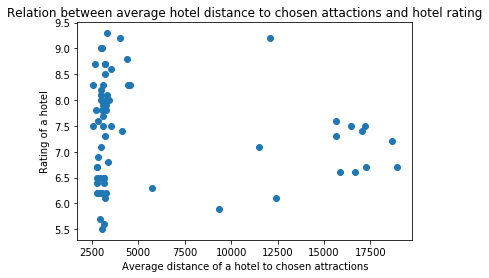

In [19]:
# Plot Scatter plot
plt.scatter(df_hotels['dist'], df_hotels['rating'])
plt.title('Relation between average hotel distance to chosen attactions and hotel rating')
plt.xlabel('Average distance of a hotel to chosen attractions')
plt.ylabel('Rating of a hotel')
plt.show()

#### Distribution of average distance of hotel to chosen attractions

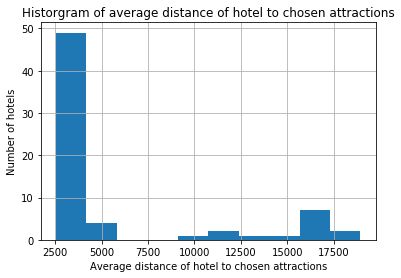

In [20]:
# Plot histogram
df_hotels['dist'].hist()
plt.title('Historgram of average distance of hotel to chosen attractions')
plt.xlabel('Average distance of hotel to chosen attractions')
plt.ylabel('Number of hotels')
plt.show()

#### Distribution of hotel rating

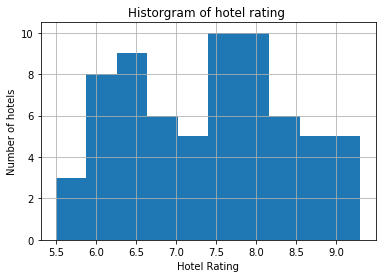

In [21]:
df_hotels['rating'].hist()
plt.title('Historgram of hotel rating ')
plt.xlabel('Hotel Rating')
plt.ylabel('Number of hotels')
plt.show()

plt.show()

#### K-means clustering into groups

In [22]:
# Normalize for kmeans
df_hotel_kmean = df_hotels.drop(columns=['name',
                                        'lat',
                                        'lng',
                                        'city',
                                        'categories'])

hotel_normalized = StandardScaler().fit_transform(df_hotel_kmean.values)


# Run k-means clustering
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, 
                random_state=0).fit(hotel_normalized)

df_hotels['cluster'] = kmeans.labels_
df_hotels.head()

,name,rating,city,lat,lng,categories,dist,cluster
0,Shangri-La Toronto,9.0,Toronto,43.649129,-79.386557,Hotel,3050.887840,2
1,Delta Hotels by Marriott Toronto,9.3,Toronto,43.642882,-79.383949,Hotel,3325.326945,2
2,The Fairmont Royal York,8.7,Toronto,43.645449,-79.381508,Hotel,3212.265661,2
3,The Ritz-Carlton Toronto,8.7,Toronto,43.645330,-79.387089,Hotel,3216.308478,2
4,The Grand Hotel & Suites Toronto,9.0,Toronto,43.656449,-79.374110,Hotel,2995.854308,2


#### Recommendation strategy

Only with clustering is not enough, we have to decide which cluster to recommend to the user. As we know that the higher the hotel rating and the shorter the distance between the hotel and chosen attractions, the better the recommendation. A simple way to represent this is simply multiply the rating and inverse of the average distance.

In [23]:
def rod(row):
    return row['rating']/row['dist']

df_hotels['rod'] = df_hotels.apply(rod, axis=1)

In [24]:
df_hotels.sort_values('rod', inplace=True, ascending=False)
df_hotels.reset_index(drop=True, inplace=True)
df_hotels.head()

,name,rating,city,lat,lng,categories,dist,cluster,rod
0,Four Seasons Hotel Toronto,8.7,Toronto,43.671796,-79.389457,Hotel,2667.946190,2,0.003261
1,The Hazelton Hotel,8.3,Toronto,43.670764,-79.393257,Hotel,2549.653127,2,0.003255
2,The Grand Hotel & Suites Toronto,9.0,Toronto,43.656449,-79.374110,Hotel,2995.854308,2,0.003004
3,Shangri-La Toronto,9.0,Toronto,43.649129,-79.386557,Hotel,3050.887840,2,0.002950
4,Windsor Arms Hotel,7.5,Toronto,43.668781,-79.390850,Hotel,2558.494501,0,0.002931


In [25]:
print('Cluster ', df_hotels['cluster'][0],'will be recommended')

Cluster  2 will be recommended


# Result

We show the clusters returned by the k-means algorithm onto the map using different colors.

In [26]:
map_tt = folium.Map(location=[df_hotels['lat'].mean(), df_hotels['lng'].mean()], 
                    zoom_start=10,
                    tiles='cartodbdark_matter')

# Add attraction markers to map
for name, lat, lng  in zip(df_attr['name'],
                           df_attr['lat'], 
                           df_attr['lng']):
   
    html="""
    Attraction: {}
    """.format(name)
    popup = folium.Popup(html=html, max_width=2650)
    
    folium.CircleMarker(
        [lat, lng],
        radius=8,
        popup=popup,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_tt)  

# Add hotel markers to map

# set color scheme for the clusters
x = np.arange(num_clusters)
ys = [i + x + (i*x)**2 for i in range(num_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

for name,lat,lng,cluster,rating,dist,rod in zip(df_hotels['name'],
                        df_hotels['lat'],
                        df_hotels['lng'],
                        df_hotels['cluster'],
                        df_hotels['rating'],
                        df_hotels['dist'],
                        df_hotels['rod']):
  
    html="""
    Hotel: {}
    <br>
    Rating: {}
    <br>
    Distance: {} m
    <br>
    Cluster: {}
    <br>
    Rod: {}
    """.format(name,rating,dist,cluster,rod)
    popup = folium.Popup(html=html, max_width=2650)

    
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=popup,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7,
        parse_html=False).add_to(map_tt)

    
# Add recommendation marker to the map
html_recommend = """
    Recommendation:
    <br>
    Hotel: {}
    <br>
    Cluster: {}
    """.format(df_hotels['name'][0], df_hotels['cluster'][0])

folium.Marker(
    [df_hotels['lat'][0], df_hotels['lng'][0]],
    popup = folium.Popup(html=html_recommend, max_width=2650)
    ).add_to(map_tt)  
    
map_tt

The hotels far away from the attractions have a distinct color from those close to the attractions. The large average distance between the hotel and attractions is making the difference in k-means clustering. The pointy marker shows the best hotel(pointy marker) to recommend and the cluster it belongs to will also be recommended.

# Dicussion

There is no data for training a model based on a human decision in this case. In fact, this is a simple recommendation based on two parameters, the average distance between the hotel and chosen attraction, the rating of the hotel. 

It is true that it is not accurate simply use the shortest distance between hotel to attractions.
If local transportation information is available, more close-to-reality travel time can be calculated. As a result, smart trip planning is also possible with transportation tips.

# Conclusion

In conclusion, this simple idea based on two parameters，the hotel ratings and the average distance hotel to attractions, to give recommendation on the hotel is possible and is close to expectation.